# Importings

In [23]:
# apply lofo 
# focus on numerical values 
# watch the tutorials of how to win ds compeition

%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [24]:
import pandas as pd                                    # for data
import numpy as np                                     # for math
from lightgbm import LGBMRegressor                     # Validation model
from sklearn.metrics import mean_squared_error         # Regressortion metric
from sklearn.model_selection import GroupKFold,KFold, TimeSeriesSplit   # for validation
from sklearn.preprocessing import LabelEncoder         # for encoding
import sklearn.manifold._t_sne as tsne                 # for t_sne
import seaborn as sns                     
from sklearn.model_selection import TimeSeriesSplit# for plotting
import matplotlib.pyplot as plt    
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
import xgboost as xgb 
train = pd.read_csv('/Users/ahmed/Downloads/computerscience/Kaggle/geoai-ground-level-no2-estimation/geoai-ground/data/Train.csv') 
test = pd.read_csv('/Users/ahmed/Downloads/computerscience/Kaggle/geoai-ground-level-no2-estimation/geoai-ground/data/Test.csv')

test_id = test['ID_Zindi']
pd.options.display.max_columns = 200



In [25]:
train.describe()

,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2
count,86584.000000,86584.000000,86584.000000,46798.000000,73709.000000,73709.000000,73709.000000,73709.000000,51111.000000,73709.000000,82051.000000
mean,45.421456,10.014272,2.585528,299.268841,-1.274999,0.200606,0.000045,0.000156,0.000105,16655.112392,24.535051
std,0.225409,1.056637,7.617394,10.927167,0.693003,0.259607,0.000012,0.000103,0.000092,3000.748790,17.108838
min,44.924694,8.736497,0.000000,253.200000,-5.196266,0.000000,0.000013,-0.000012,-0.000025,8614.349685,0.000000
25%,45.249544,9.195325,0.000000,290.920000,-1.749425,0.023900,0.000034,0.000100,0.000047,14432.114060,11.875000
50%,45.478996,9.611738,0.000000,300.760000,-1.349746,0.078478,0.000047,0.000122,0.000071,16711.190570,20.000000
75%,45.601232,10.683357,0.000000,307.940000,-0.878857,0.278451,0.000056,0.000173,0.000129,19252.648570,33.050000
max,45.889734,12.590682,135.396805,327.840000,2.143020,1.000000,0.000073,0.002047,0.001097,24449.007150,188.233333


In [26]:
def post_process(test_data,y,feature_to_mean='date_month') -> int:

    test_data['target'] = y
    test_data['target_month'] = test_data[feature_to_mean].map(test_data[[feature_to_mean,'target']].groupby(feature_to_mean)['target'].mean())
    test_data.drop(columns='target',inplace=True)
    return test_data['target_month']

# Exploratoray Data Analysis

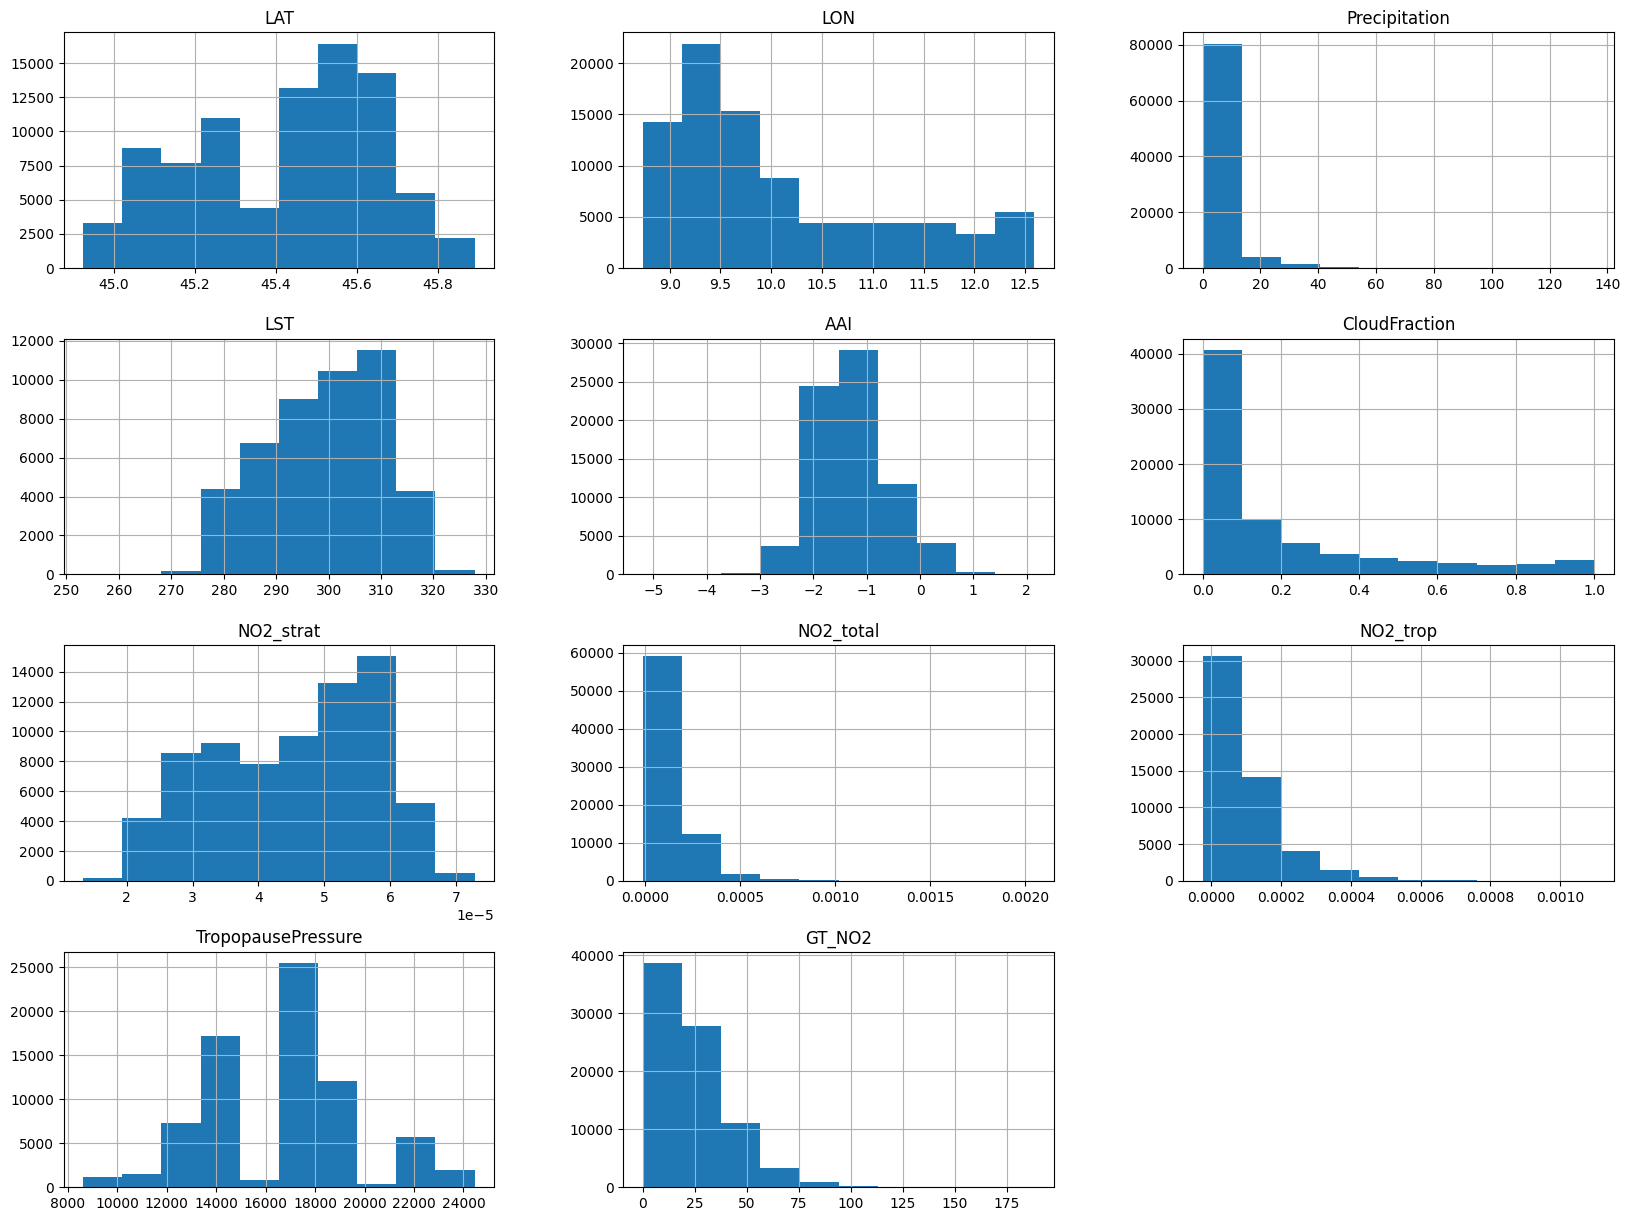

In [27]:
num_feats = list(train.select_dtypes(include=['int64', 'float64', 'int32']).columns)
train[num_feats].hist(figsize=(20,15));

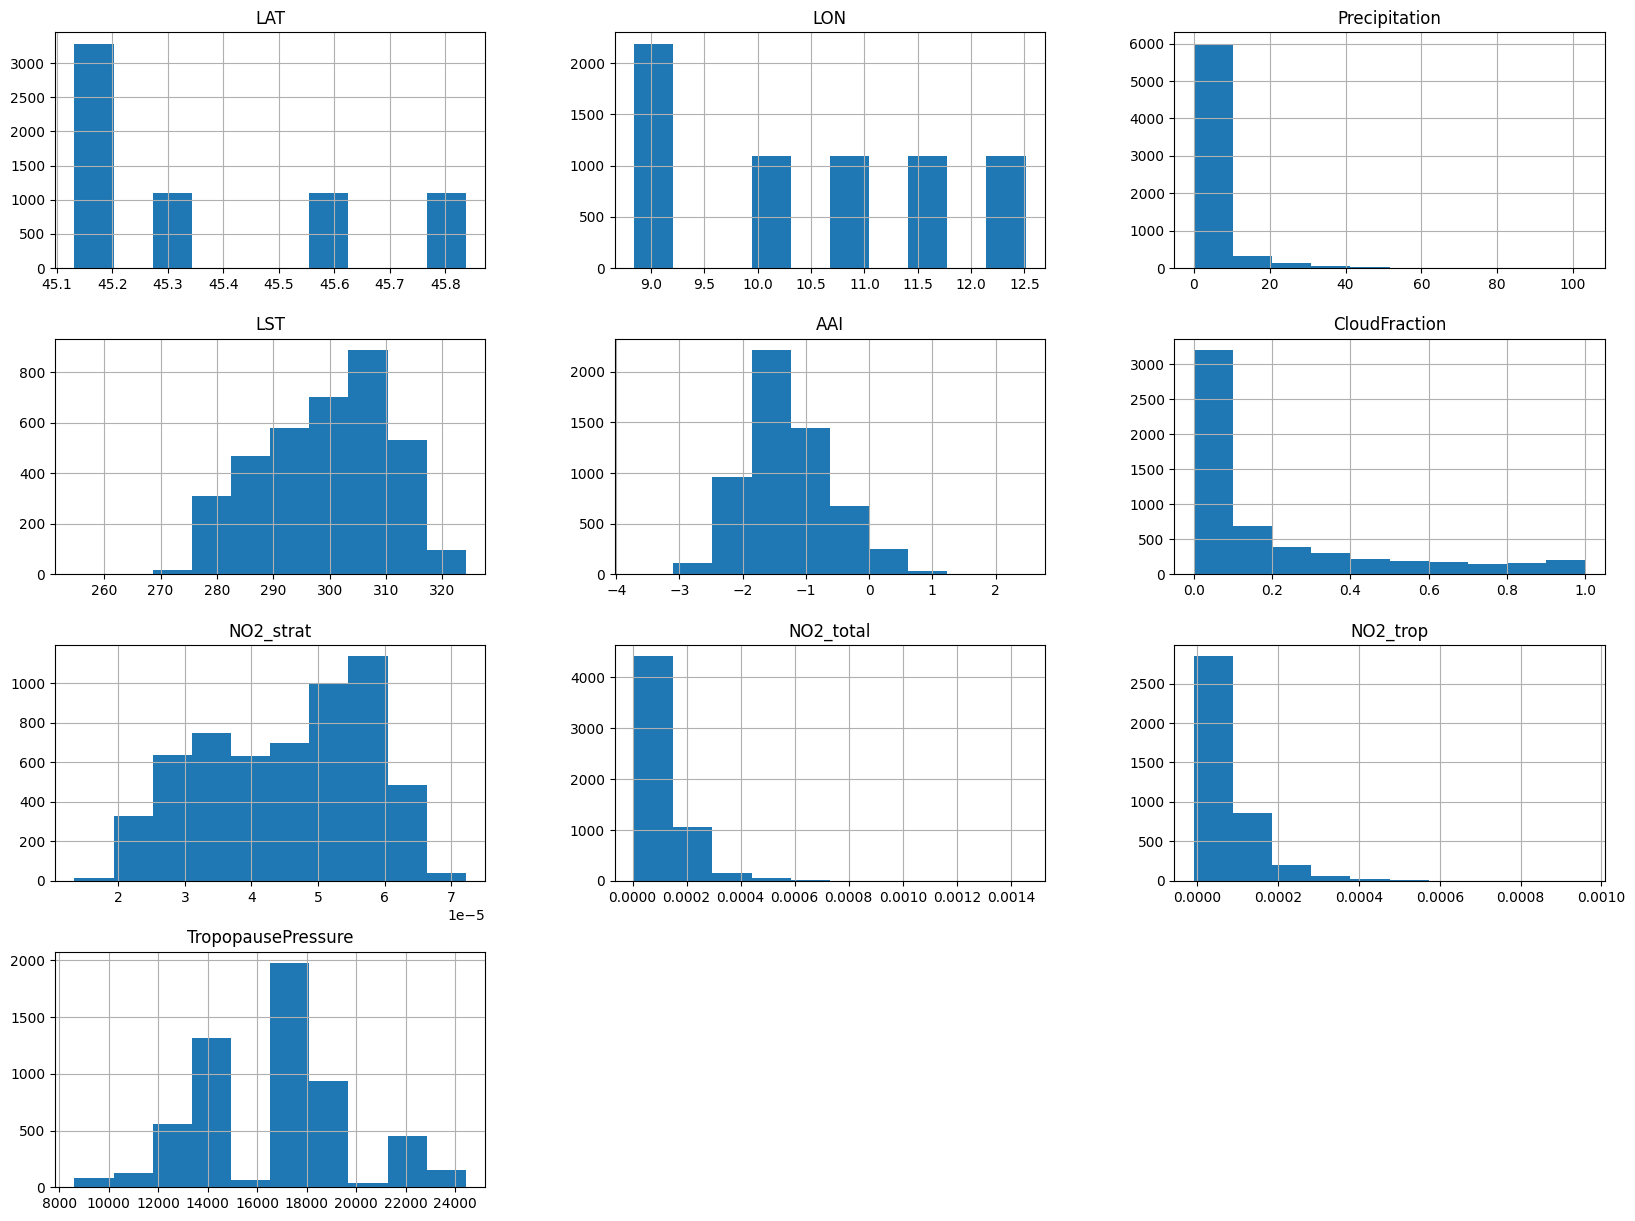

In [28]:
num_feats = list(test.select_dtypes(include=['int64', 'float64', 'int32']).columns)
test[num_feats].hist(figsize=(20,15));

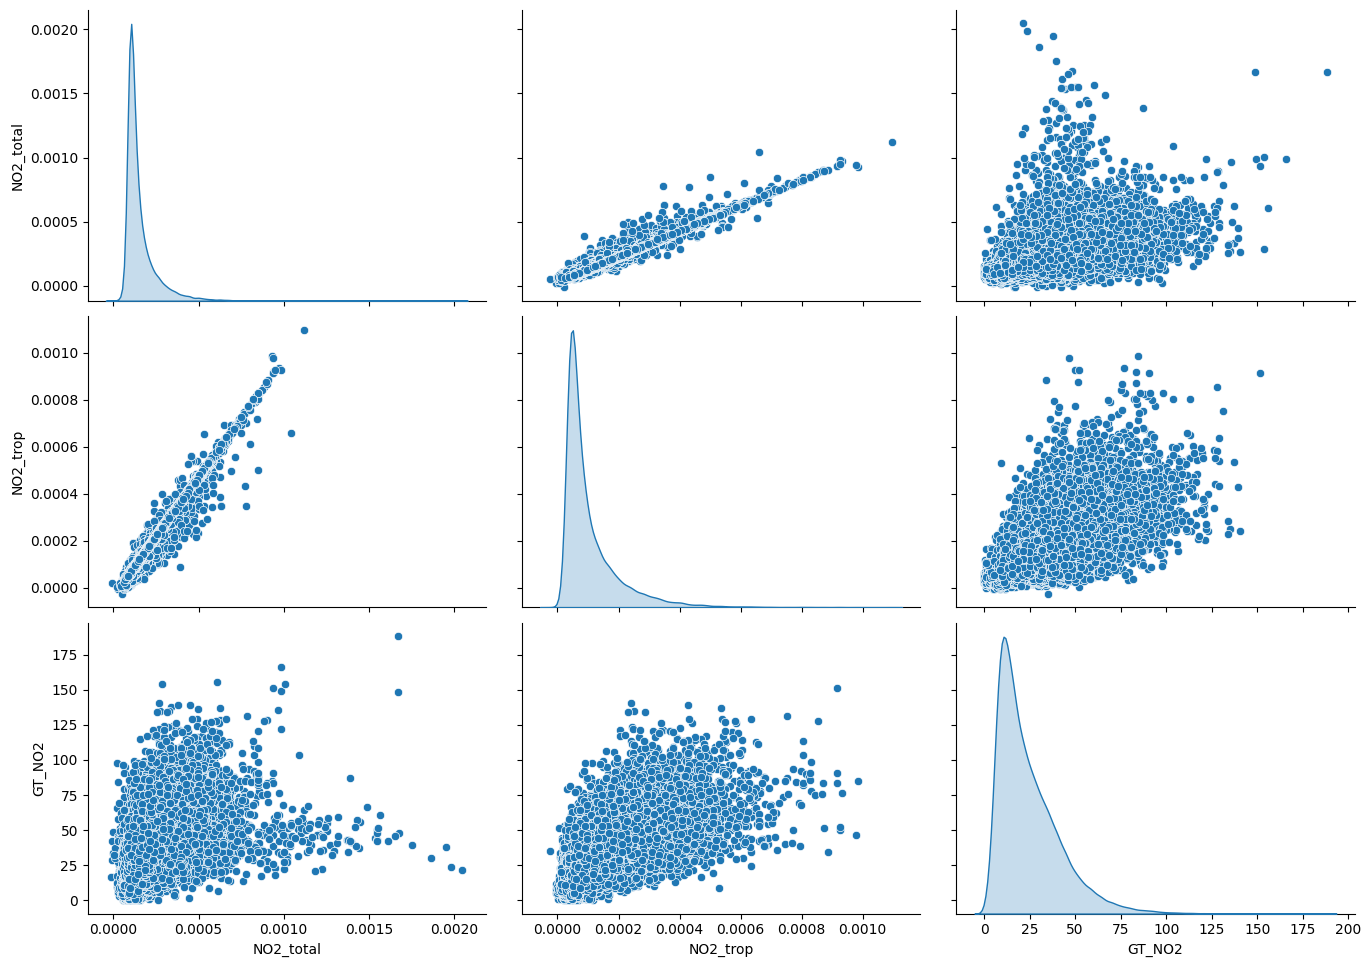

In [29]:
attributes = ["NO2_total", "NO2_trop","GT_NO2"]
sns.pairplot(train[attributes], diag_kind="kde")
plt.gcf().set_size_inches(15, 10)

In [30]:
"""num_feats = train.select_dtypes(include='float')

plt.figure(figsize=(14,6))
sns.pairplot(num_feats)
plt.show()"""

"num_feats = train.select_dtypes(include='float')\n\nplt.figure(figsize=(14,6))\nsns.pairplot(num_feats)\nplt.show()"

<Axes: >

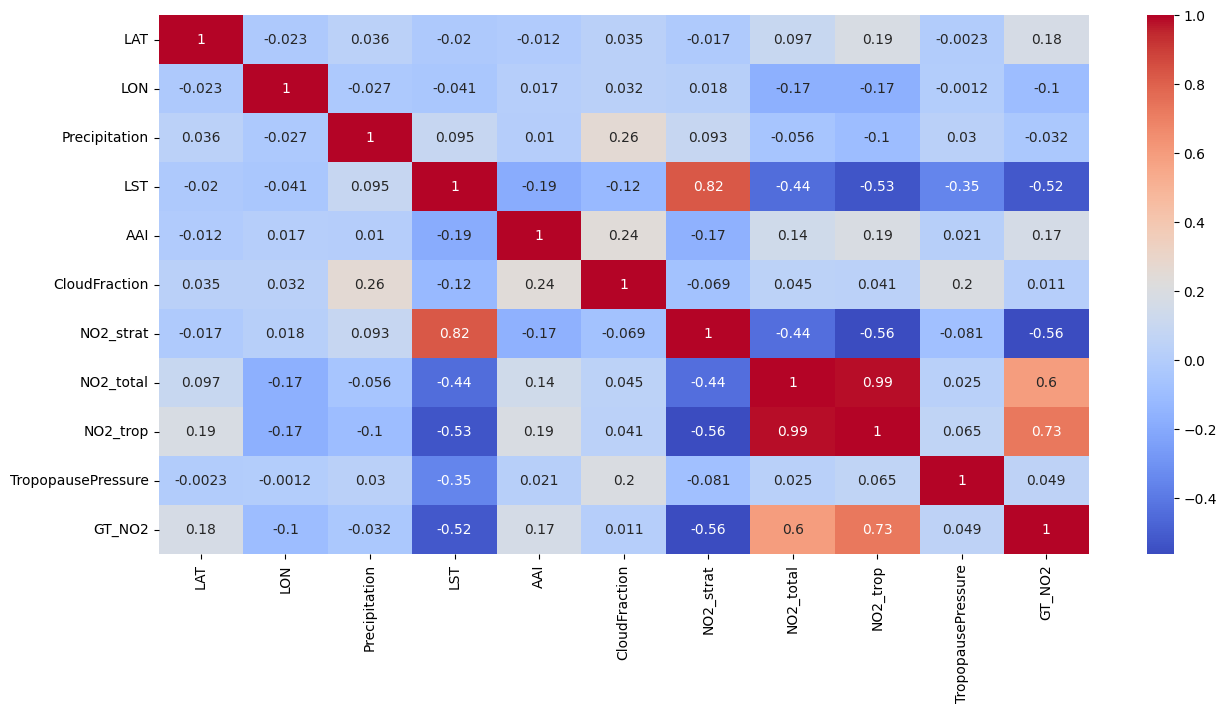

In [31]:
num_feats = train.select_dtypes(include='float')
corrs = num_feats.corr()
plt.figure(figsize=(15,7))
sns.heatmap(corrs, cmap='coolwarm', annot=True)

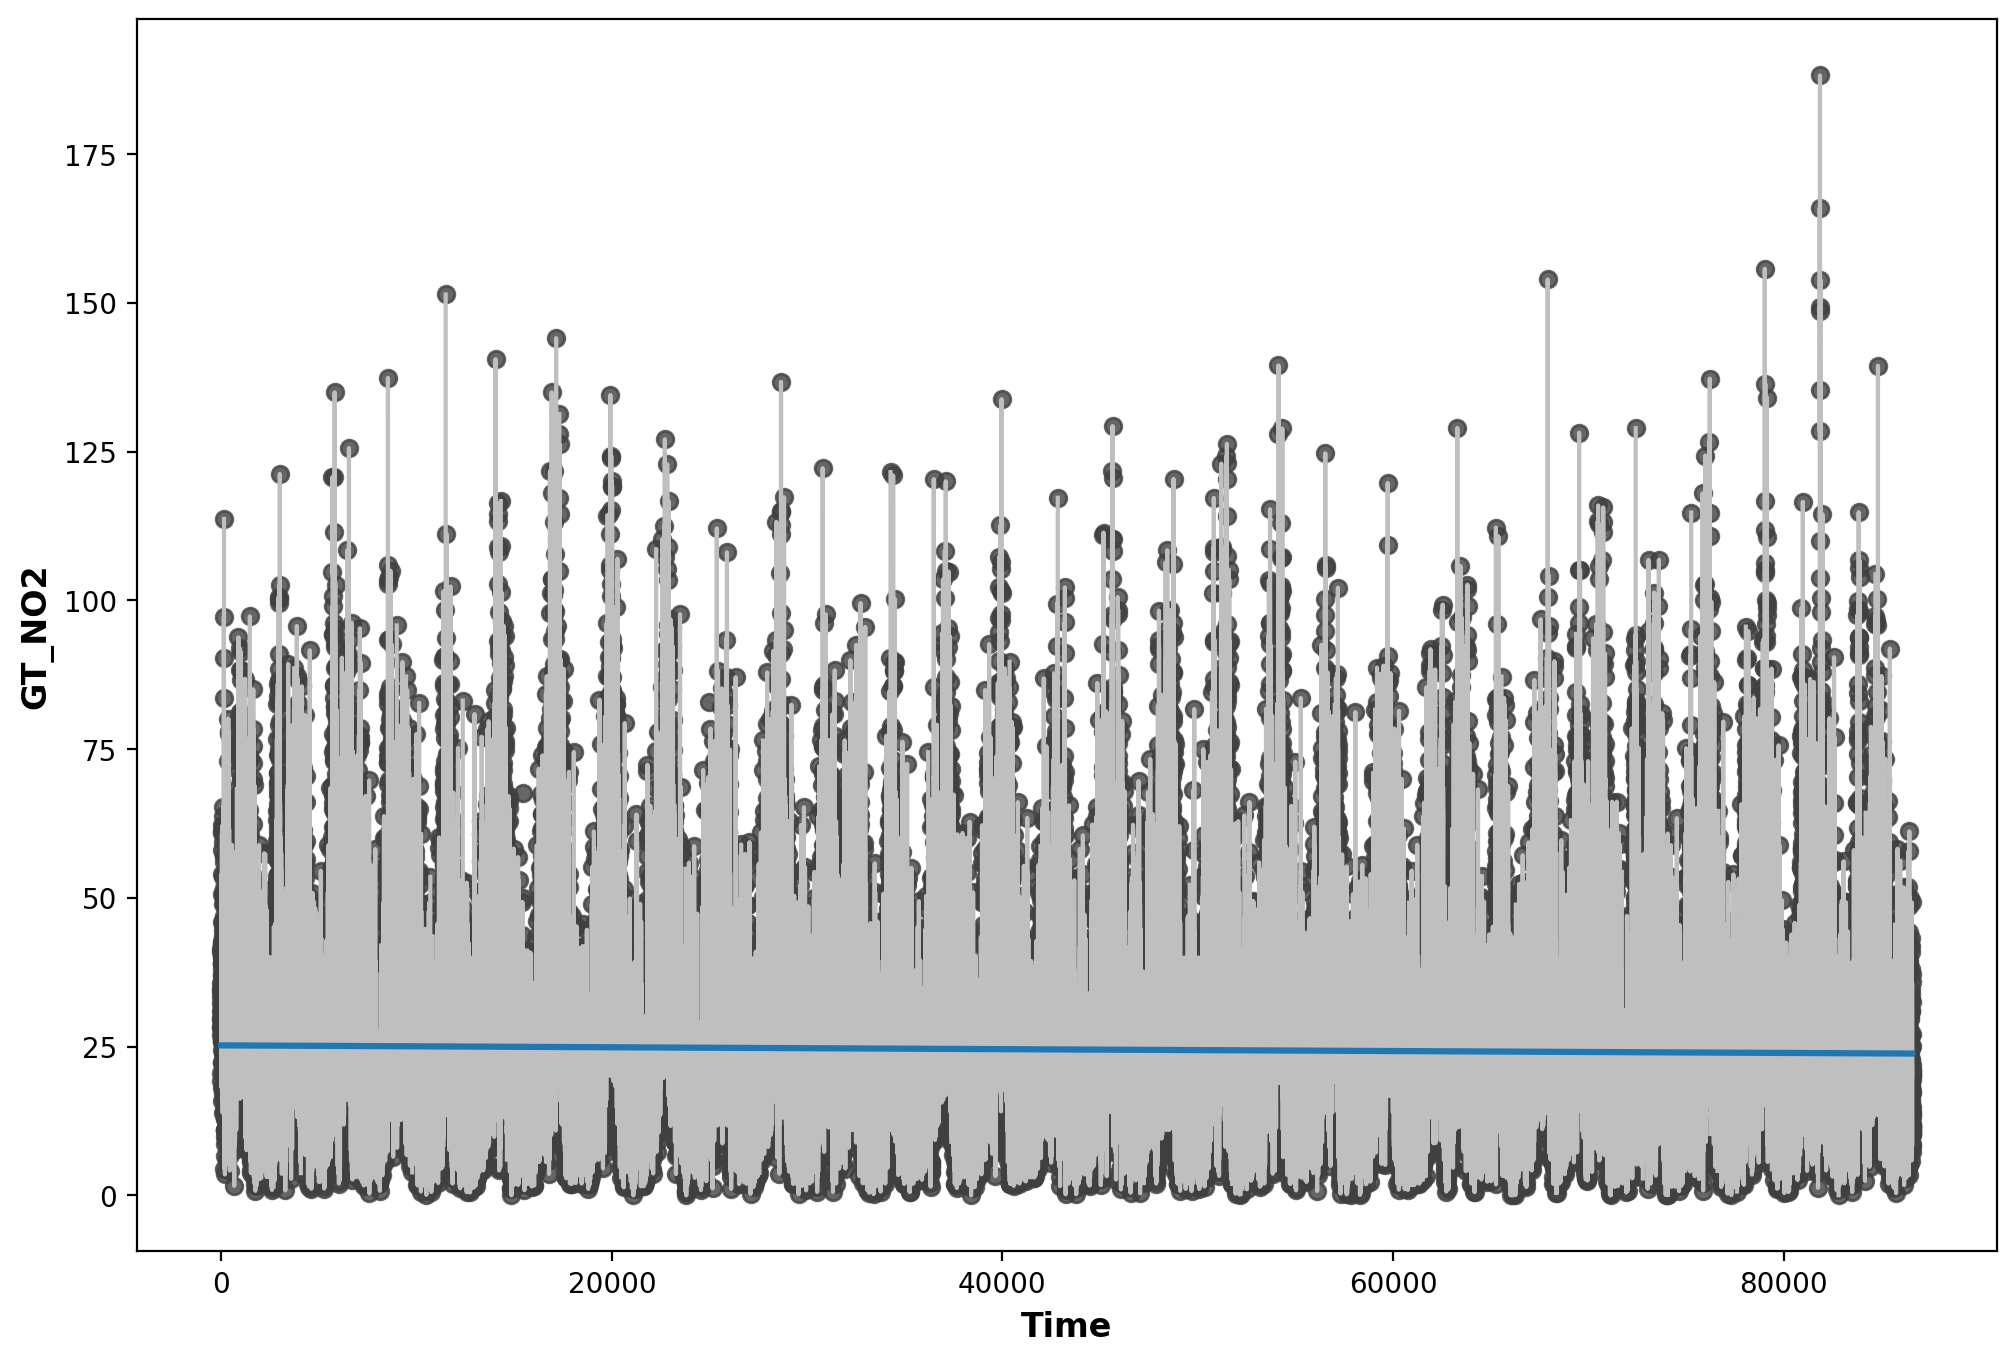

In [48]:
train['Time'] = np.arange(len(train.index))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()
ax.plot('Time', 'GT_NO2', data=train, color='0.75')
ax = sns.regplot(x='Time', y='GT_NO2', data=train, ci=None, scatter_kws=dict(color='0.25'))

# Feature Engineering

In [32]:
num_feats.columns

Index(['LAT', 'LON', 'Precipitation', 'LST', 'AAI', 'CloudFraction',
       'NO2_strat', 'NO2_total', 'NO2_trop', 'TropopausePressure', 'GT_NO2'],
      dtype='object')

In [33]:
train = train.sort_values('Date').reset_index(drop=True) 
test = test.sort_values('Date').reset_index(drop=True)

for df in (train,test):
    df['Date'] = pd.to_datetime(df['Date'])
    #df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
    #df['date_ofyear'] = df['Date'].dt.day_of_year
    df['DayOfWeek'] =  df['Date'].dt.dayofweek
    df['Day'] =  df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['Month'] = df['Date'].dt.is_month_start
    df['Year'] =  df['Date'].dt.year
    df.set_index(df['Date'],inplace=True)
    df.drop(columns=['ID_Zindi','Date'],inplace=True)
#Lags
for df in(train,test): 
    df['feature_lag_previous_1'] = df['Day'].shift(1)
    df['feature_lag_next_1'] = df['Day'].shift(-1)
for df in(train,test): 
    df['Precipitation_inter1'] = df['TropopausePressure'] + df['Precipitation']
    df['cloud_fraction1'] = df['CloudFraction'] % df['NO2_strat']
    df['cloud_fraction1'] = df['CloudFraction'] % df['NO2_total']
    df['agg_no2'] = (df['NO2_total'] + df['NO2_strat']).mean()

for df in(train,test): 
    #Rolling (Moving Average)
    df['feature_rolling_3_mean'] = df['TropopausePressure'].rolling(3).mean()
    df['feature_rolling_7_mean'] = df['TropopausePressure'].rolling(7).mean()
    df['feature_rolling_7_std'] = df['TropopausePressure'].rolling(7).std()
#statsitics of similar variables

def MeanSd(feature1, feature2):
    for dataset in (train,test):
        dataset["SD"] = dataset[[feature1,feature2]].std(axis=1)
        dataset["MEAN"] = dataset[[feature1,feature2]].mean(axis=1)

MeanSd('NO2_trop','NO2_total')

/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_81844/3977993325.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])
/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_81844/3977993325.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


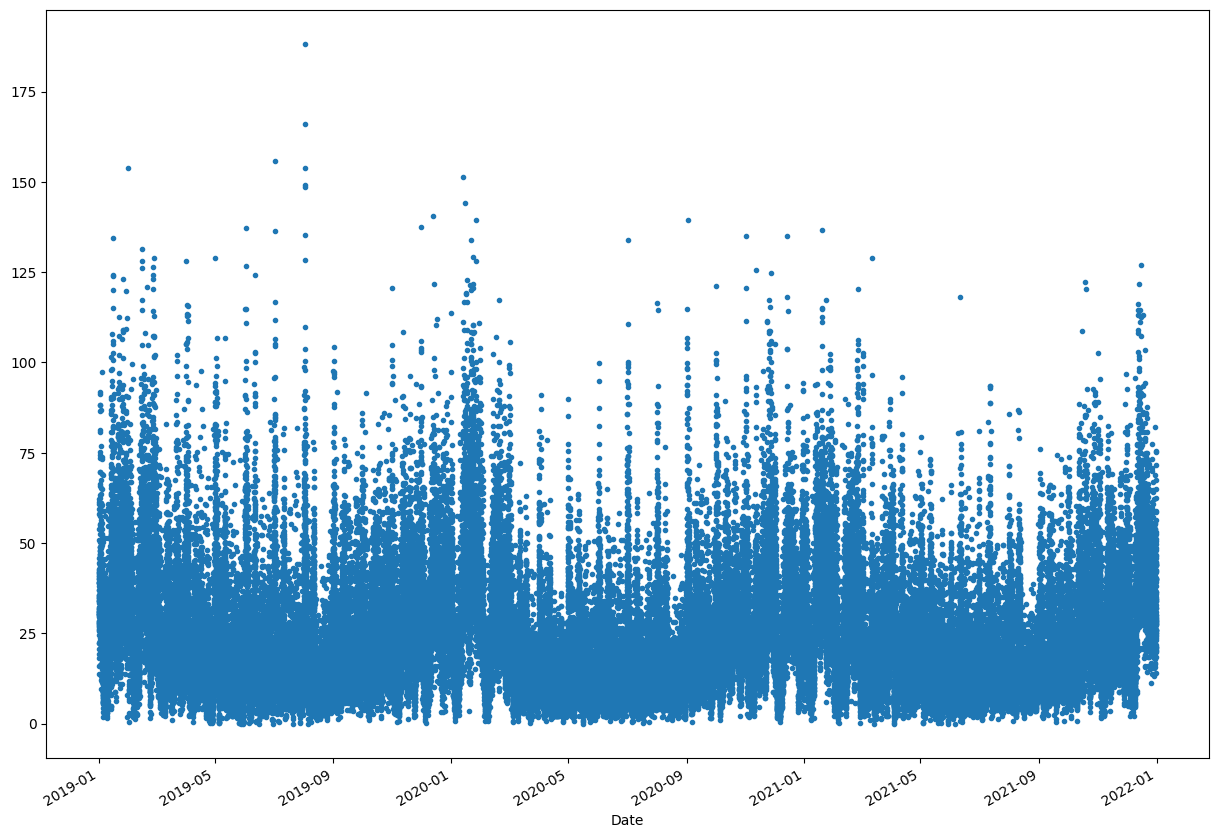

In [34]:
train['GT_NO2'].plot(style='.',figsize=(15,11))
plt.show()

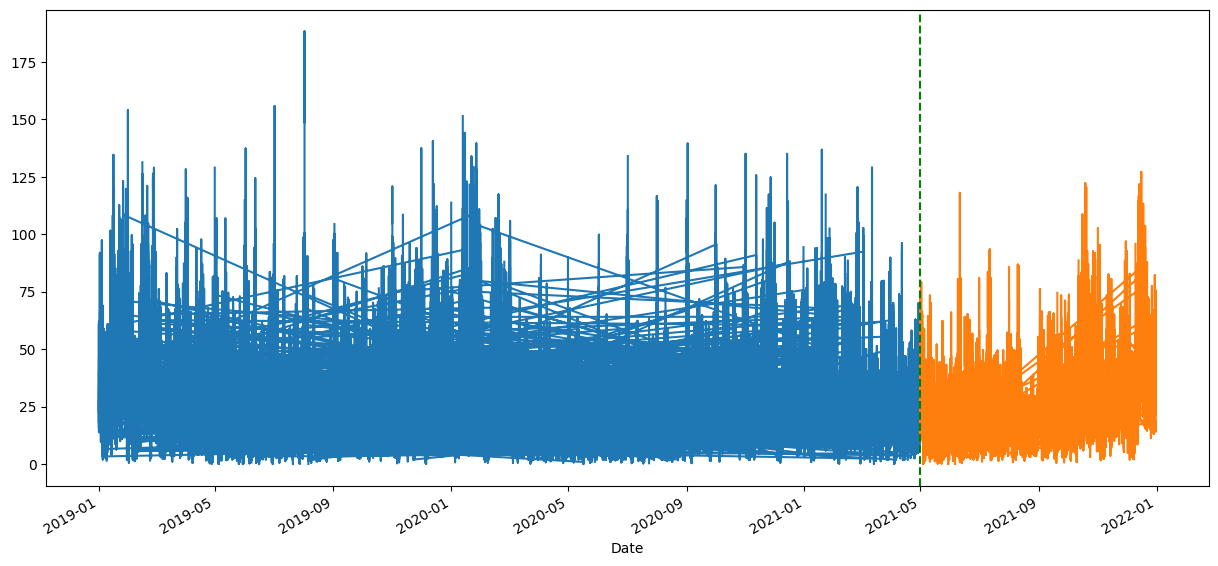

In [35]:
trainset = train.loc[train.index < '05-01-2021']
validation  =  train.loc[train.index >= '05-01-2021']
fig , ax = plt.subplots(figsize=(15,7))
trainset['GT_NO2'].plot(ax=ax, label='training_set')
validation['GT_NO2'].plot(ax=ax, label='Test_set')
ax.axvline('05-01-2021', color='green',ls='--')
plt.show()

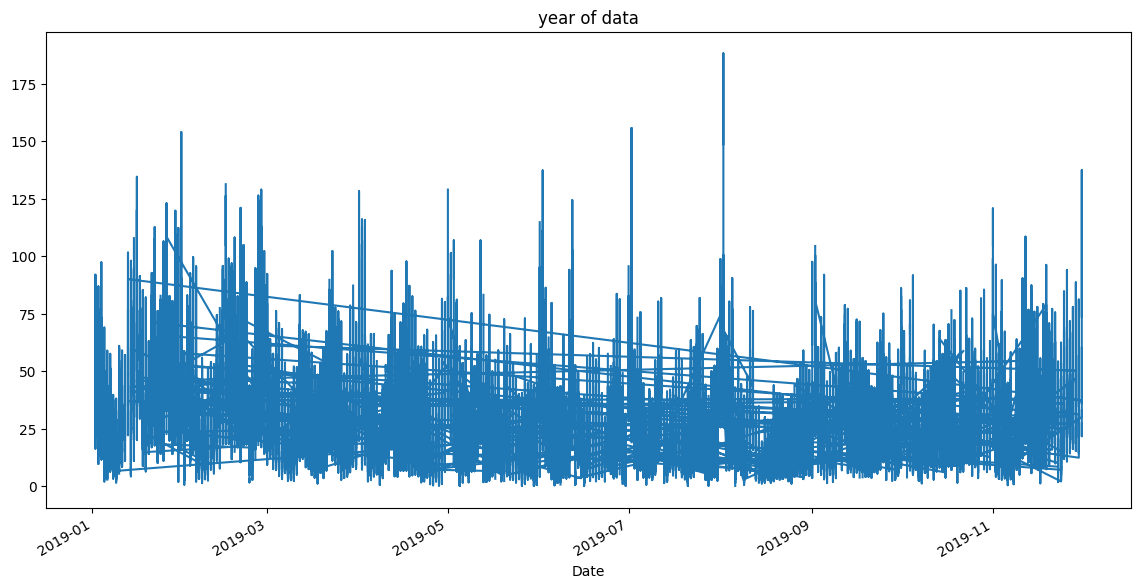

In [36]:
train['GT_NO2'].loc[((train.index > '01-01-2019') & (train.index <='12-01-2019'))].plot(figsize=(14,7), title='year of data')
plt.show()

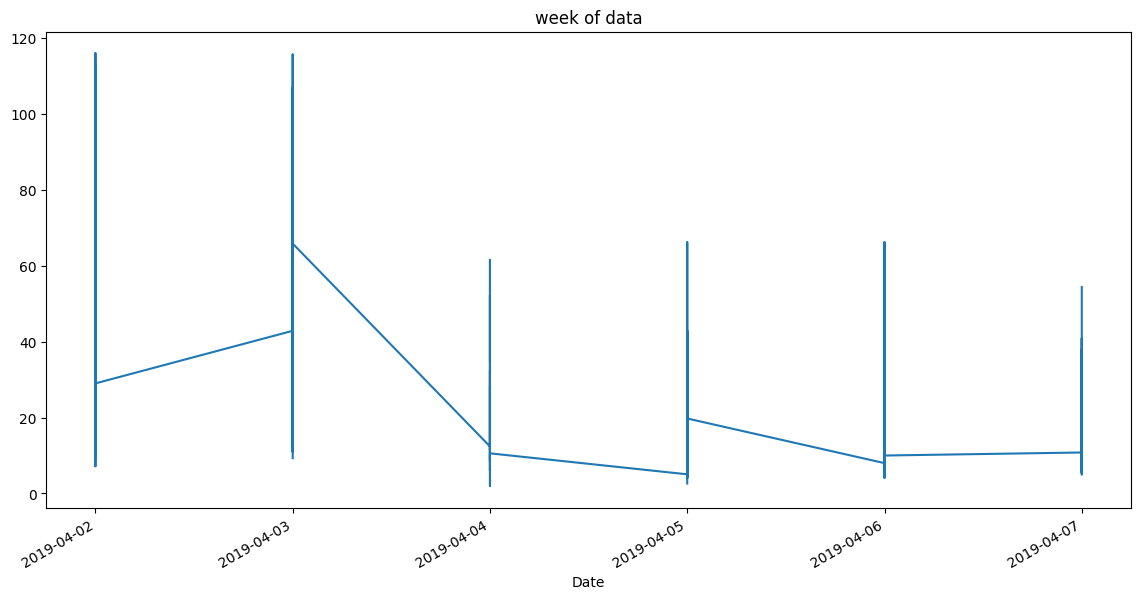

In [37]:
train['GT_NO2'].loc[(train.index > '04-01-2019') & (train.index <='04-07-2019')].plot(figsize=(14,7), title='week of data')
plt.show()

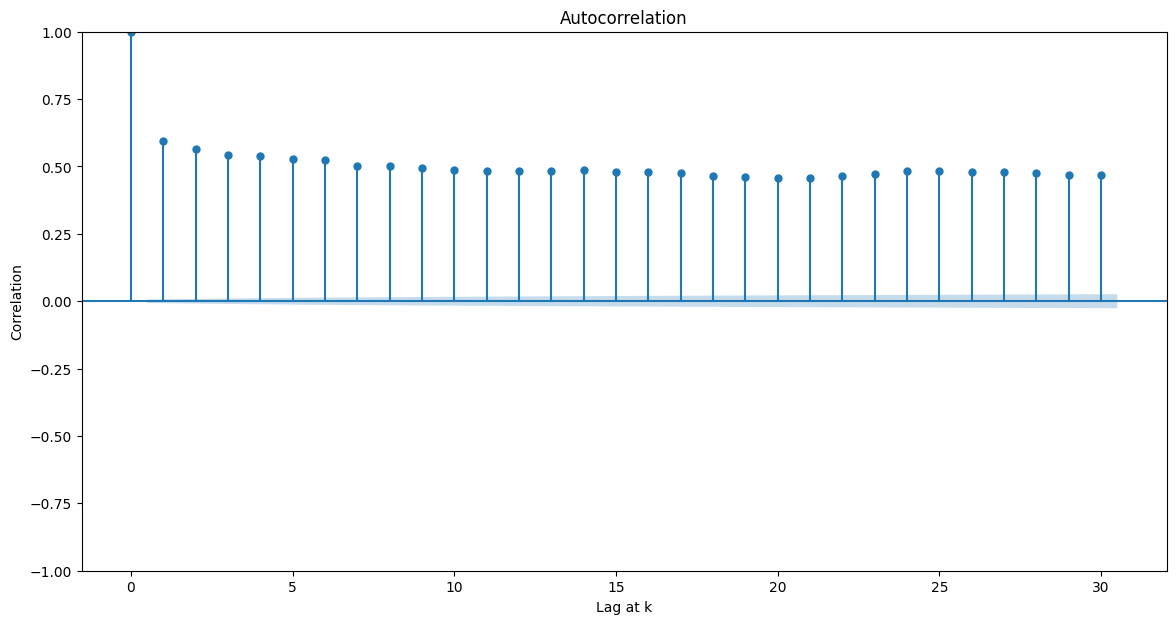

In [38]:
#AutoCorrelation Plot

rcParams["figure.figsize"] = 14, 7
fig = plot_acf(train["GT_NO2"].ffill(), lags=30)

plt.title("Autocorrelation")
plt.ylabel("Correlation")
plt.xlabel("Lag at k")
plt.show();

/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_81844/3944936905.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_rng = pd.date_range(start='1/1/2019', end='1/1/2022', freq='M')


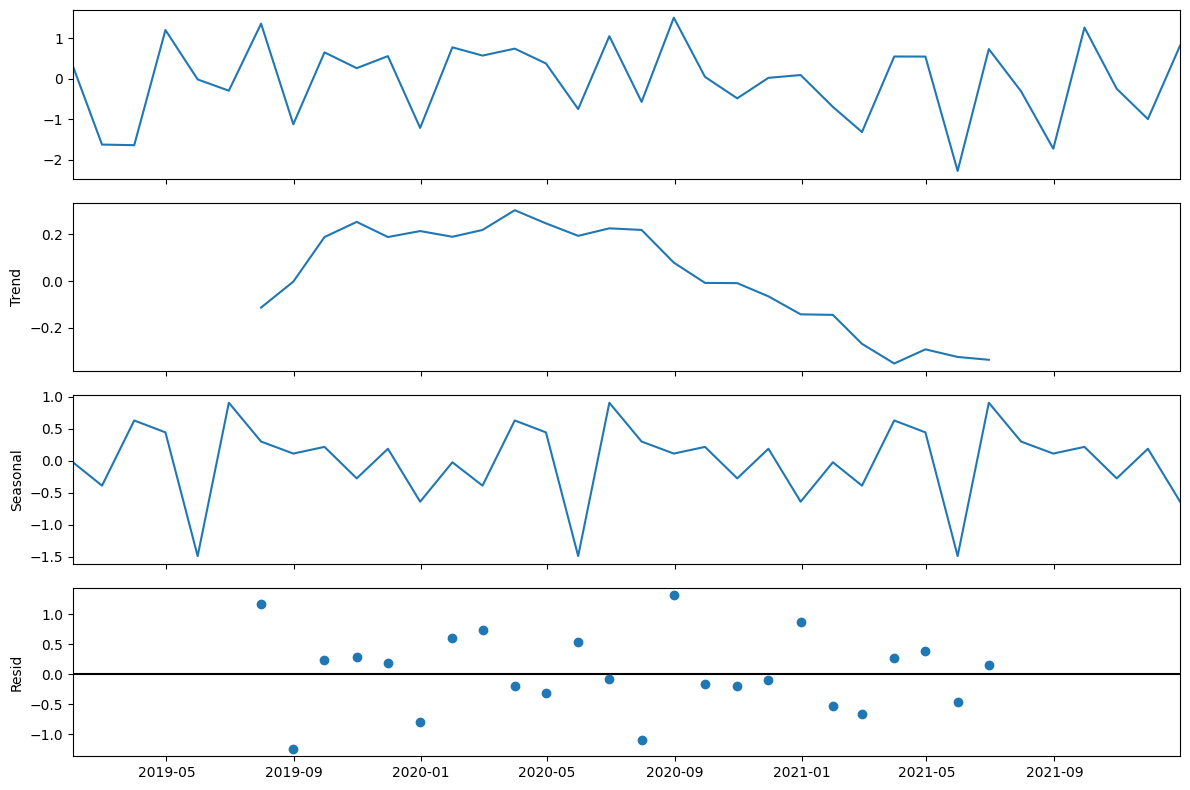

In [39]:
date_rng = pd.date_range(start='1/1/2019', end='1/1/2022', freq='M')
bio = pd.Series(np.random.randn(len(date_rng)), index=date_rng)
bio = pd.Series(bio, index=date_rng)
CFG = {'img_dim1': 12, 'img_dim2': 8}
plt.rcParams.update({'figure.figsize': (CFG['img_dim1'], CFG['img_dim2'])})
decomposition = seasonal_decompose(bio, period=12)
figure = decomposition.plot()
plt.show()

In [40]:
le = LabelEncoder()
for df in(train,test): 
    for col in df.columns: 
        if df[col].dtype == 'object': 
            df[col] = le.fit_transform(df[col])

# Missing Values & Encoding

In [41]:
"""from sklearn.impute import KNNImputer
groups = train['ID']

combined = pd.concat([train, test], keys=['train', 'test'])
imputer = KNNImputer(n_neighbors=2)
imputed_data = imputer.fit_transform(combined)
imputed_df = pd.DataFrame(imputed_data, columns=combined.columns, index=combined.index)

train = imputed_df.loc['train'].reset_index(drop=True)
train = imputed_df.loc['test'].reset_index(drop=True)"""

"from sklearn.impute import KNNImputer\ngroups = train['ID']\n\ncombined = pd.concat([train, test], keys=['train', 'test'])\nimputer = KNNImputer(n_neighbors=2)\nimputed_data = imputer.fit_transform(combined)\nimputed_df = pd.DataFrame(imputed_data, columns=combined.columns, index=combined.index)\n\ntrain = imputed_df.loc['train'].reset_index(drop=True)\ntrain = imputed_df.loc['test'].reset_index(drop=True)"

In [42]:
"""from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd

combined = pd.concat([train, test], keys=['train', 'test'])
imputer = IterativeImputer(max_iter=10, random_state=0)
imputed_data = imputer.fit_transform(combined)

imputed_df = pd.DataFrame(imputed_data, columns=combined.columns, index=combined.index)

train = imputed_df.loc['train'].reset_index(drop=True)
test = imputed_df.loc['test'].reset_index(drop=True)"""

"from sklearn.experimental import enable_iterative_imputer\nfrom sklearn.impute import IterativeImputer\nimport pandas as pd\n\ncombined = pd.concat([train, test], keys=['train', 'test'])\nimputer = IterativeImputer(max_iter=10, random_state=0)\nimputed_data = imputer.fit_transform(combined)\n\nimputed_df = pd.DataFrame(imputed_data, columns=combined.columns, index=combined.index)\n\ntrain = imputed_df.loc['train'].reset_index(drop=True)\ntest = imputed_df.loc['test'].reset_index(drop=True)"

# CV and Modeling

In [ ]:
groups = train['ID']
model =  LGBMRegressor(random_state=7)
n_splits = 5
n = train['GT_NO2'].count()
num_bins = int(1 + np.log2(n))
train['GT_NO2_bins'] = pd.cut(train['GT_NO2'], bins=num_bins, labels=False)
#test['GT_NO2_bins'] = pd.cut(test['GT_NO2'], bins=num_bins, labels=False)

In [43]:
cv = GroupKFold(n_splits=n_splits)

def validate(trainset,testset,t,origin):
    model.fit(trainset.drop(columns=t),trainset[t])
    pred = model.predict(np.array(testset.drop(columns=t)))
    print('std: ', testset[t].std())
    # pred = post_process(origin,pred,'date_month')

    origin['GT_NO2'] = pred
    pred = origin['ID'].map(origin[['ID','GT_NO2']].groupby('ID')['GT_NO2'].mean())
    stds.append(testset[t].std())
    score = mean_squared_error(pred,testset[t],squared=False)
    print('score:', score)
    return score
stds = []
rmse = []
for v_train,v_test in cv.split(train.drop(columns='GT_NO2'),train['GT_NO2'],groups=groups):
    train_v, test_v= train.iloc[v_train],train.iloc[v_test]
    origin = train.iloc[v_test]
    rmse.append(validate(train_v,test_v,'GT_NO2',origin))
np.array(rmse).mean()
np.array(rmse).std()

In [44]:
model = xgb.XGBRegressor(n_estimator=1000)
cv = TimeSeriesSplit(n_splits=4)
rmse= []
for v_train,v_test in cv.split(train.drop(columns='GT_NO2'),train['GT_NO2']):
    train_v, test_v= train.iloc[v_train],train.iloc[v_test]
    model.fit(train_v.drop(columns='GT_NO2'),train_v['GT_NO2'])
    mape = mean_squared_error(model.predict(test_v.drop(columns='GT_NO2')),test_v['GT_NO2'])
    rmse.append(mape)
    print(np.sqrt(mape))

model.fit(train.drop(columns='GT_NO2'),train['GT_NO2'])
y_predict = model.predict(test)



XGBoostError: [14:01:14] /Users/runner/work/xgboost/xgboost/src/data/data.cc:514: Check failed: valid: Label contains NaN, infinity or a value too large.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000013c123c35 dmlc::LogMessageFatal::~LogMessageFatal() + 117
  [bt] (1) 2   libxgboost.dylib                    0x000000013c2e3331 xgboost::MetaInfo::SetInfoFromHost(xgboost::Context const&, xgboost::StringView, xgboost::Json) + 4113
  [bt] (2) 3   libxgboost.dylib                    0x000000013c2e2210 xgboost::MetaInfo::SetInfo(xgboost::Context const&, xgboost::StringView, xgboost::StringView) + 496
  [bt] (3) 4   libxgboost.dylib                    0x000000013c13a67c XGDMatrixSetInfoFromInterface + 236
  [bt] (4) 5   libffi.8.dylib                      0x000000010e211972 ffi_call_unix64 + 82
  [bt] (5) 6   ???                                 0x00007ffee47395d0 0x0 + 140732731200976



In [ ]:
model.fit(train.drop(columns='GT_NO2'),train['GT_NO2'])
y_pred = model.predict(test)
sub_df = pd.DataFrame({'id': test_id,'GT_NO2':y_pred})
sub_df.to_csv('/Users/ahmed/Downloads/computerscience/Kaggle/geoai-ground-level-no2-estimation/geoai-ground/submissions/submission8300738760020405.csv', index=False)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 6576, number of used features: 18
[LightGBM] [Info] Start training from score 22.202375


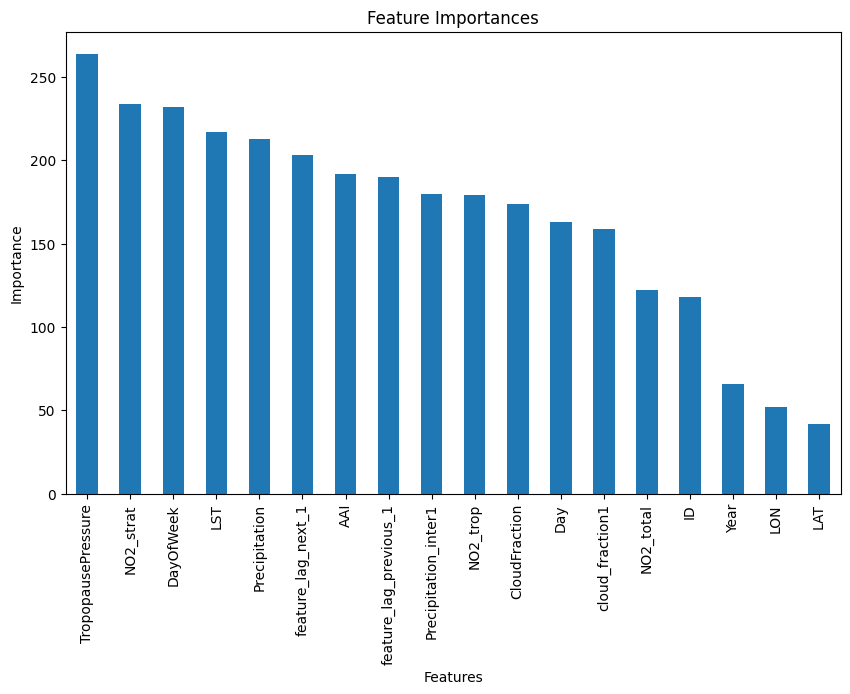

In [ ]:
importances = model.feature_importances_
names = model.feature_name_
fi = pd.DataFrame({'Feature': names,
                   'importances': importances})
fi = fi.sort_values(by='importances', ascending=False)


fi.plot(kind='bar', x='Feature', y='importances', legend=False, figsize=(10, 6))
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()
